# Part 1: Decision Tree for categorical data

Implementation details:

1. The program first reads the input using pandas' read_csv() function and the dataset is divided into training data(80%) and test data(20%).
2. We then assign X and Y as attibutes and label respectively for the decision tree.
3. Data structure used to store the decision tree object is a dictionary where keys represent either attribute or its value. At the first level, attribute is stored, then its value at second level, then onother atrribute and so on. This way the decision tree is a n-ary tree.
4. The function build_decision_tree() builds the decision tree object by recursively creating nodes. Each node contains a question for a peritcular attribute and stlits the node into n subnodes where each subnode has a perticular category for that attribute, e.g. the attribute salary has categories n=3 categories: low, medium and high.
5. We choose the attribute based on the information gain. One with the highest information gain is chosen each time. The calculations are based on entropy.
6. After an attribute is selected at a node, it is dropped and it cannot appear again in that subtree.
7. There are three stopping criterias for decision tree splitting: when information gain of each attribute is less than 0.0001, when the purity of data in a node increases by 0.65(calculated by entropy), when there are no more attributes left.
8. We then use the validation data to predict the label using the decision tree and match the results with actual label and then report accuracy, precision, recall and F1 measure.

In [1]:
import pandas
import numpy
import pprint
from numpy import log2 as log

csv_path = raw_input("Enter path to input CSV file: ")
dataset = pandas.read_csv(csv_path)

#split data into train data and validation data
splitted = numpy.split(dataset, [int(.8 * len(dataset.index))])
data = splitted[0].reset_index()
validation_data = splitted[1].reset_index()

Enter path to input CSV file: decision_Tree/train.csv


We inititalize X and Y as the attributes and label respectively for the decision tree

In [2]:
X = dataset.keys()[[5,7,8,9]]
Y = 'left'

The following function 'choose_best_attribute()' takes a set of data as input and returns the best attribute which has maximum information gain. The calculations are based on entropy.

In [3]:
def choose_best_attribute(data, x):
    
    if len(x) == 1:
        return x[0]
    
    notLeft_count = len(data[data[Y] == 0])
    left_count = len(data[data[Y] == 1])
    entropy = 0.0
    
    if left_count == 0 or notLeft_count == 0:
        #in this case entropy_val = 0
        pass
    else:
        q = float(left_count) / (left_count + notLeft_count)
        entropy = - ( q*log(q) + (1-q)*log(1-q) )
    
    max_info_gain = float(-99999999999)
    
    for att in x:
        entropy_split = 0.0
        attValue = numpy.unique(data[att])
        
        for value in attValue:
            subdata = data[data[att] == value]
            notLeft_count_split = len(subdata[subdata[Y] == 0])
            left_count_split = len(subdata[subdata[Y] == 1])
            
            if left_count_split == 0 or notLeft_count_split == 0:
                #in this case entropy_split_val = 0
                continue
            else:
                q = float(left_count_split) / (left_count_split + notLeft_count_split)
                
            entropy_split_val = - ( q*log(q) + (1-q)*log(1-q) )
            weight = float( len(subdata.index) ) / len(data.index)
            
            entropy_split += weight * entropy_split_val
            
        info_gain = entropy - entropy_split
        
        if info_gain > max_info_gain:
            max_info_gain = info_gain
            bestAtt = att
    
    if max_info_gain <= 0.0001:  #threshold for information gain
        return 'noBest'
    
    return bestAtt

This function 'check_purity()' is used to calculate the purity of labels in a dataset. Along with the purity, it also returns the majority label value.

In [4]:
def check_purity(y):
    left_count = 0
    notLeft_count = 0
    
    for value in y:
        if value == 1:
            left_count = left_count + 1
        else:
            notLeft_count = notLeft_count + 1

    if left_count == 0:
        return 1, 0
    elif notLeft_count == 0:
        return 1, 1
    
    impurity = 0.0
    q = float(left_count) / (left_count + notLeft_count)
    
    impurity = - ( q*log(q) + (1-q)*log(1-q) )
        
    purity = 1 - impurity
    
    if left_count > notLeft_count:
        return purity, 1
    else:
        return purity, 0

The function below actually builds the decision tree recursively using dictionary keys as nodes. It stops when purity of a node increases some threshold or when there are no attributes left with good information gain. It makes sense to drop an atrribute once it has been used in a branch, so attributes occur only once in a branch.

In [5]:
def build_decision_tree(data, x, tree = None): 
    
    #if pure enough
    purity, majority = check_purity(data[Y])
    
    if purity > 0.65: #Threshold for purity
        return majority

    #get an attribute with maximum information gain
    bestAtt = choose_best_attribute(data, x)
    if bestAtt == 'noBest':
        return majority
    
    if tree == None:                    
        tree = {}
        tree[bestAtt] = {}
    
    #take distinct values of that attribute
    attValue = numpy.unique(dataset[bestAtt])
    
    #for all categorical values keep groing tree
    for value in attValue:
        subdata = data[data[bestAtt] == value]
        
        tree[bestAtt][value] = build_decision_tree(subdata, x.drop(bestAtt)) #Calling the function recursively 
                   
    return tree
    
    
decision_tree = build_decision_tree(data, X)
pprint.pprint(decision_tree)

{'Work_accident': {0: {'salary': {'high': {'sales': {'IT': 0,
                                                     'RandD': {'promotion_last_5years': {0: 0,
                                                                                         1: 0}},
                                                     'accounting': 0,
                                                     'hr': {'promotion_last_5years': {0: 0,
                                                                                      1: 0}},
                                                     'management': 0,
                                                     'marketing': {'promotion_last_5years': {0: 0,
                                                                                             1: 0}},
                                                     'product_mng': {'promotion_last_5years': {0: 0,
                                                                                               1: 0}},
                

We now calculate the performance measures for the decision tree using the validation data. In our case we want high recall because we do not want an employee to leave the company when we have no clue that he/she would leave.

In [6]:
def predict(row, tree):
    
    for nodes in tree.keys():        
        value = row[nodes]
        value = value.tolist()
        value = value[0]
        tree = tree[nodes][value]
        prediction = 0
            
        if type(tree) is dict:
            prediction = predict(row, tree)
        else:
            prediction = tree
            break                        
        
    return prediction


def calculate_performance(validation_data, tree):
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    
    for i in range(len(validation_data.index)):
        row = validation_data.iloc[[i]][Y]
        row = row.tolist()
        row = row[0]
        if predict(validation_data.iloc[[i]], tree) == 1:
            if row == 1:
                TP += 1
            else:
                FP += 1
        else:
            if row == 0:
                TN += 1
            else:
                FN += 1

    accuracy = float(TP + TN) / (TP + TN + FP + FN)
    
    if TP + FP == 0:
        precision = 0
    else:
        precision = float(TP) / (TP + FP)
        
    if TP + FN == 0:
        recall = 0
    else:
        recall = float(TP) / (TP + FN)
        
    F1measure = 2.0 / ( (1/recall) + (1/precision) )
        
    print ("Validation Results:\n")
    print ("accuracy = " + str(accuracy))
    print ("precision = " + str(precision))
    print ("recall = " + str(recall))
    print ("F1 measure = " + str(F1measure))


calculate_performance(validation_data, decision_tree)

Validation Results:

accuracy = 0.758007117438
precision = 1.0
recall = 0.00183486238532
F1 measure = 0.003663003663


Observations:

1. Our decision tree predicts 0 most of the time.
2. In validation data, we have 75.75% of zeros and our accuracy is just above that because we predict 0 most of the time.
3. The information gain of these attributes is very low, that's why we are not able to achieve good predictions.

# Part 2: Decision Tree for all attributes including numeric

Implementation details:

1. We distinguish between categorical and non categorical attributes using the function is_categorical().
2. The splitting for a numerical attribute is binary. We find the value at which splitting produces maximum information gain. We do this by checking split at each unique value in the dataset for that attribute.
3. Unlike the categorical attribute, the numerical attributes can appear again in a subtree.
4. For numerical data, insted of string a value in the node of decision tree, we store the range in the format "start~end" where the range is [start,end]
5. The code can be modified for calculations of impurity for entropy, gini-index and misclassification.

We first update our attribute list to contain all the attributes including numeric attributes.

In [7]:
X = dataset.keys()[[0,1,2,3,4,5,7,8,9]]

The function is_categorical() takes an attribute name as input and returns true if the atrribute is categorical, otherwise returns false.

In [8]:
def is_categorical(att):
    if att in dataset.keys()[[5,6,7,8,9]]:
        return True
    else:
        return False

The function Range_set() is used to decide the best spliiting point in a numeric attribute. It calculates the information gain for all unique values of an attribue in a dataset and tries to split the node in terms of values greater than this value and less than this value. Then it returns the splitting value at which information gain is maximum.

In [9]:
def Range_set(att, data, measure = 'entropy'):
    
    notLeft_count = len(data[data[Y] == 0])
    left_count = len(data[data[Y] == 1])
    impurity = 0.0
    
    q = float(left_count) / (left_count + notLeft_count)
    if measure == 'entropy':
        impurity = - ( q*log(q) + (1-q)*log(1-q) )
    elif measure == 'gini':
        impurity = 4 * q * (1-q) #scaled to [0,1]
    elif measure == 'misclassification':
        impurity = 2 * min(q, 1-q) #scaled to [0,1]
            
    attValue = numpy.unique(data[att])
    attValue.sort()
    max_info_gain = 0.0
    max_at = attValue[0] + 0.0005
    i = 0
    while i < len(attValue) - 1:
        impurity_split = 0.0
        
        mid = float( attValue[i] + attValue[i+1] ) / 2
        i += 1
        left_data = data[data[att] < mid]
        right_data = data[data[att] >= mid]
        
        notLeft_count_split = len(left_data[left_data[Y] == 0])
        left_count_split = len(left_data[left_data[Y] == 1])

        if left_count_split == 0 or notLeft_count_split == 0:
            #in this case entropy_split_val = 0
            continue
        else:
            q = float(left_count_split) / (left_count_split + notLeft_count_split)

        if measure == 'entropy':
            impurity_split_val = - ( q*log(q) + (1-q)*log(1-q) )
        elif measure == 'gini':
            impurity_split_val = 4 * q * (1-q) #scaled to [0,1]
        elif measure == 'misclassification':
            impurity_split_val = 2 * min(q, 1-q) #scaled to [0,1]

        weight = float( len(left_data.index) ) / len(data.index)

        impurity_split += weight * impurity_split_val
        
        
        notLeft_count_split = len(right_data[right_data[Y] == 0])
        left_count_split = len(right_data[right_data[Y] == 1])

        if left_count_split == 0 or notLeft_count_split == 0:
            #in this case entropy_split_val = 0
            continue
        else:
            q = float(left_count_split) / (left_count_split + notLeft_count_split)

        if measure == 'entropy':
            impurity_split_val = - ( q*log(q) + (1-q)*log(1-q) )
        elif measure == 'gini':
            impurity_split_val = 4 * q * (1-q) #scaled to [0,1]
        elif measure == 'misclassification':
            impurity_split_val = 2 * min(q, 1-q) #scaled to [0,1]

        weight = float( len(right_data.index) ) / len(data.index)

        impurity_split += weight * impurity_split_val
        
        info_gain = impurity - impurity_split
        if info_gain > max_info_gain:
            max_info_gain = info_gain
            max_at = mid
    
    return [ str(attValue[0]) + '~' + str(max_at),  str(max_at) + '~' + str(attValue[len(attValue)-1]) ]

The choose_best_attribute() function is now modified to handle numeric atrributes.
If numerical data is chosen as best attribute, it will now return a list of ranges to split the data. 

In [10]:
def choose_best_attribute(data, x, measure='entropy'):
    Ranges = []
    ranges = []
    if len(x) == 1:
        return x[0], Ranges
    
    notLeft_count = len(data[data[Y] == 0])
    left_count = len(data[data[Y] == 1])
    impurity = 0.0
    if left_count == 0 or notLeft_count == 0:
        #in this case entropy_val = 0
        return 'noBest', Ranges
    else:
        q = float(left_count) / (left_count + notLeft_count)
        if measure == 'entropy':
            impurity = - ( q*log(q) + (1-q)*log(1-q) )
        elif measure == 'gini':
            impurity = 4 * q * (1-q)
        elif measure == 'misclassification':
            impurity = 2 * min(q, 1-q)

    max_info_gain = float(-99999999999)
    
    for att in x:
        impurity_split = 0.0
        
        if is_categorical(att):
            attValue = numpy.unique(data[att])
            for value in attValue:
                subdata = data[data[att] == value]
                notLeft_count_split = len(subdata[subdata[Y] == 0])
                left_count_split = len(subdata[subdata[Y] == 1])
                
                if left_count_split == 0 or notLeft_count_split == 0:
                    #in this case entropy_split_val = 0
                    continue
                else:
                    q = float(left_count_split) / (left_count_split + notLeft_count_split)
    
                if measure == 'entropy':
                    impurity_split_val = - ( q*log(q) + (1-q)*log(1-q) )
                elif measure == 'gini':
                    impurity_split_val = 4 * q * (1-q)
                elif measure == 'misclassification':
                    impurity_split_val = 2 * min(q, 1-q)
                    
                weight = float( len(subdata.index) ) / len(data.index)
            
                impurity_split += weight * impurity_split_val
        
        else:
            ranges = Range_set(att, data, measure)
            Range = ranges[0].split('~')
            subdata = data[(data[att] >= float(Range[0])) & (data[att] < float(Range[1]))]
            notLeft_count_split = len(subdata[subdata[Y] == 0])
            left_count_split = len(subdata[subdata[Y] == 1])

            if left_count_split == 0 or notLeft_count_split == 0:
                #in this case entropy_split_val = 0
                continue
            else:
                q = float(left_count_split) / (left_count_split + notLeft_count_split)

            if measure == 'entropy':
                impurity_split_val = - ( q*log(q) + (1-q)*log(1-q) )
            elif measure == 'gini':
                impurity_split_val = 4 * q * (1-q) #scaled to [0,1]
            elif measure == 'misclassification':
                impurity_split_val = 2 * min(q, 1-q) #scaled to [0,1]

            weight = float( len(subdata.index) ) / len(data.index)

            impurity_split += weight * impurity_split_val

            Range = ranges[1].split('~')
            subdata = data[(data[att] >= float(Range[0])) & (data[att] <= float(Range[1]))]
            notLeft_count_split = len(subdata[subdata[Y] == 0])
            left_count_split = len(subdata[subdata[Y] == 1])

            if left_count_split == 0 or notLeft_count_split == 0:
                #in this case entropy_split_val = 0
                continue
            else:
                q = float(left_count_split) / (left_count_split + notLeft_count_split)

            if measure == 'entropy':
                impurity_split_val = - ( q*log(q) + (1-q)*log(1-q) )
            elif measure == 'gini':
                impurity_split_val = 4 * q * (1-q) #scaled to [0,1]
            elif measure == 'misclassification':
                impurity_split_val = 2 * min(q, 1-q) #scaled to [0,1]

            weight = float( len(subdata.index) ) / len(data.index)

            impurity_split += weight * impurity_split_val
        
        info_gain = impurity - impurity_split
        
        if info_gain > max_info_gain:
            max_info_gain = info_gain
            bestAtt = att
            Ranges = ranges
    
    if max_info_gain <= 0.0001:
        return 'noBest', Ranges
    
    return bestAtt, Ranges


def check_purity(y, measure = 'entropy'):
    left_count = 0
    notLeft_count = 0
    
    for value in y:
        if value == 1:
            left_count = left_count + 1
        else:
            notLeft_count = notLeft_count + 1
            
    if left_count + notLeft_count < 5:
        if left_count > notLeft_count:
            return 1, 1
        else:
            return 1, 0

    elif left_count == 0:
        return 1, 0
    elif notLeft_count == 0:
        return 1, 1
    
    impurity = 0.0
    q = float(left_count) / (left_count + notLeft_count)
    
    if measure == 'entropy':
        impurity = - ( q*log(q) + (1-q)*log(1-q) )
    if measure == 'gini':
        impurity = 4 * q * (1-q)
    if measure == 'misclassification':
        impurity = 2 * min(q, 1-q)
        
    purity = 1 - impurity
    #print purity
    
    if left_count > notLeft_count:
        return purity, 1
    
    else:
        return purity, 0

The function 'build_decision_tree()' is also modified. If the best attribute chosen is numeric, Then it will be called recursively for the range below the best split and above the best split.
For numerical data, insted of string a value in the node of decision tree, we store the range in the format "start~end" where the range is [start,end]

In [11]:
def build_decision_tree(data, x, measure = 'entropy', tree = None): 
    
    #if pure enough
    purity, majority = check_purity(data[Y], measure)
    
    if measure == 'entropy' and purity > 0.7:
        return majority
    if measure == 'gini' and purity > 0.75:
        return majority
    if measure == 'misclassification' and purity > 0.97:
        return majority

    #get an attribute with maximum information gain
    bestAtt, Range_str = choose_best_attribute(data, x, measure)
    if bestAtt == 'noBest':
        return majority
    
    if tree == None:                    
        tree = {}
        tree[bestAtt] = {}
    
    if is_categorical(bestAtt):
        #for all categorical values keep growing tree
        attValue = numpy.unique(dataset[bestAtt])
        for value in attValue:
            subdata = data[data[bestAtt] == value]
            tree[bestAtt][value] = build_decision_tree(subdata, x.drop(bestAtt), measure) #Calling the function recursively 
    
    else:
        #divide the numerical data in specified range(s)
        Range = Range_str[0].split('~')
        subdata = data[(data[bestAtt] >= float(Range[0])) & (data[bestAtt] < float(Range[1]))]
        
        tree[bestAtt][Range_str[0]] = build_decision_tree(subdata, x, measure)
        
        Range = Range_str[1].split('~')
        subdata = data[(data[bestAtt] >= float(Range[0])) & (data[bestAtt] <= float(Range[1]))]
        
        tree[bestAtt][Range_str[1]] = build_decision_tree(subdata, x, measure)
            
    return tree
    

decision_tree = build_decision_tree(data, X)
pprint.pprint(decision_tree)

{'satisfaction_level': {'0.09~0.465': {'number_project': {'2.5~7': {'satisfaction_level': {'0.09~0.125': 1,
                                                                                           '0.125~0.46': {'sales': {'IT': 0,
                                                                                                                    'RandD': 0,
                                                                                                                    'accounting': {'average_montly_hours': {'203.0~285': {'last_evaluation': {'0.42~0.465': {'satisfaction_level': {'0.24~0.26': 1,
                                                                                                                                                                                                                                    '0.26~0.28': 1}},
                                                                                                                                                     

If the attribute is numeric, in the predict() function, we need to check if the row value lies between the range.

In [12]:
def predict(row, tree):
    for nodes in tree.keys():
        value = row[nodes]
        #print value
        value = value.tolist()
        value = value[0]
        #print nodes
        if not is_categorical(nodes):
            found = False
            for Range_str in tree[nodes].keys():
                #print Range_str
                Range = Range_str.split('~')
                if value >= float(Range[0]) and value <= float(Range[1]):
                    value = Range_str
                    found = True
            
            if not found:
                Range_str = tree[nodes].keys()[0]
                if value < float(Range[0]):
                    value = Range_str
                
                Range_str = tree[nodes].keys()[len(tree[nodes].keys())-1]
                if value > float(Range[1]):
                    value = Range_str
                    
        #print nodes, value
        tree = tree[nodes][value]
        prediction = 0
            
        if type(tree) is dict:
            prediction = predict(row, tree)
        else:
            prediction = tree
            break;                            
    
    return prediction


def calculate_performance(validation_data):
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    
    for i in range(len(validation_data.index)):
        row = validation_data.iloc[[i]][Y]
        row = row.tolist()
        row = row[0]
        if predict(validation_data.iloc[[i]], decision_tree) == 1:
            if row == 1:
                TP += 1
            else:
                FP += 1
        else:
            if row == 0:
                TN += 1
            else:
                FN += 1

    accuracy = float(TP + TN) / (TP + TN + FP + FN)
    
    if TP + FP == 0:
        precision = 0
    else:
        precision = float(TP) / (TP + FP)
        
    if TP + FN == 0:
        recall = 0
    else:
        recall = float(TP) / (TP + FN)
        
    F1measure = 2.0 / ( (1/recall) + (1/precision) )
        
    print ("Validation Results:\n")
    print ("accuracy = " + str(accuracy))
    print ("precision = " + str(precision))
    print ("recall = " + str(recall))
    print ("F1 measure = " + str(F1measure))


calculate_performance(validation_data)

Validation Results:

accuracy = 0.965747330961
precision = 0.936567164179
recall = 0.921100917431
F1 measure = 0.928769657724


Observations:

1. By adding the numerical attributes, performance measures are significantly increased.
2. Numerical attributes have high information gain.
3. Attributes satisfaction_level and number_project are the major attributes in the decision tree.

# Part 3: Effectiveness of Misclassification rate, Gini, Entropy as impurity measures

We build our decision tree for these three impurity measures and calculate performance measures.

In [13]:
decision_tree = build_decision_tree(data, X, 'gini')
print ("GINI INDEX:\n")
calculate_performance(validation_data)

decision_tree = build_decision_tree(data, X, 'entropy')
print ("\n\nENTROPY:\n")
calculate_performance(validation_data)

decision_tree = build_decision_tree(data, X, 'misclassification')
print ("\n\nMISCLASSIFICATION RATE:\n")
calculate_performance(validation_data)

GINI INDEX:

Validation Results:

accuracy = 0.965747330961
precision = 0.941509433962
recall = 0.915596330275
F1 measure = 0.928372093023


ENTROPY:

Validation Results:

accuracy = 0.965747330961
precision = 0.936567164179
recall = 0.921100917431
F1 measure = 0.928769657724


MISCLASSIFICATION RATE:

Validation Results:

accuracy = 0.92793594306
precision = 0.975186104218
recall = 0.721100917431
F1 measure = 0.829113924051


Observations:

From this we can conclude that the performance for entropy and gini index is almost similar but for misclassification it is slightly low.
These results were tested for different values of purity as stopping criteria.
For entropy, maximum performance is achieved when stopping criteria is purity > 0.7 .
For gini, when purity > 0.75 .
For misclassification, when purity > 0.97 .

# Part 4: Visualizing two attributes of training data on a 2D plot

Implementation details:

1. We can plot graphs in python using matplotlib library. 
2. We choose to take attributes 'satisfaction_level' and 'last_evaluation' because they have high information gain and are continuous.

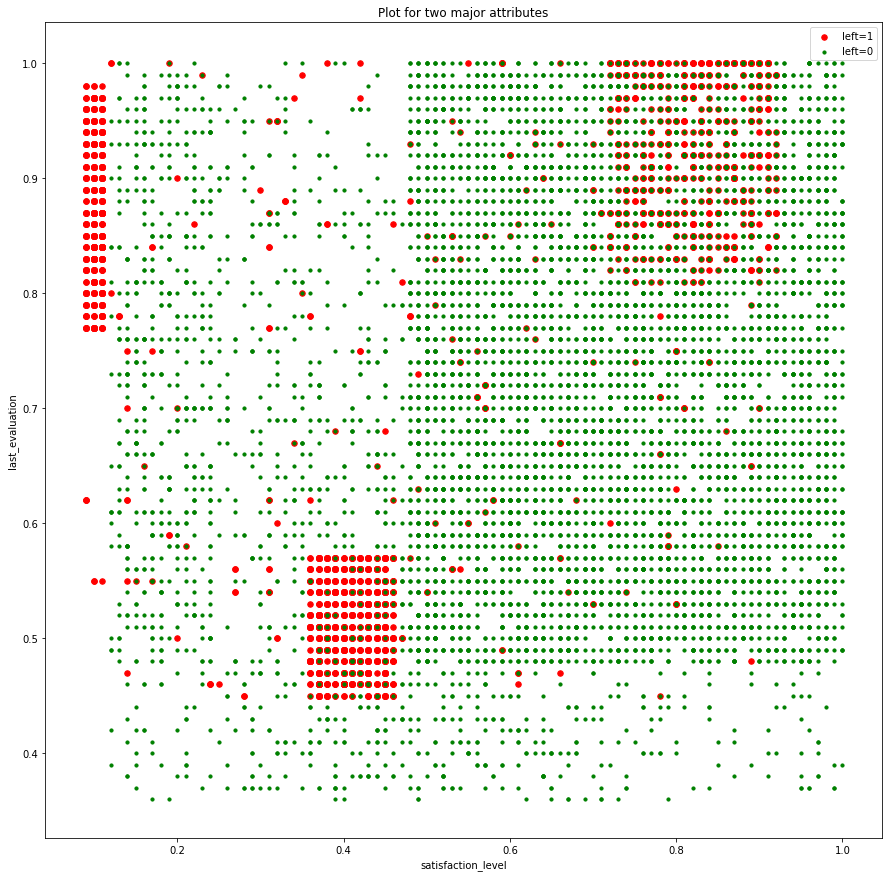

In [15]:
import matplotlib.pyplot as plt

att1 = 'satisfaction_level'
att2 = 'last_evaluation'

plt.figure(figsize=(15,15))
x = dataset[dataset[Y] == 1][att1]
y = dataset[dataset[Y] == 1][att2]

plt.scatter(x, y, label = 'left=1', color = 'red', s = 30)

x = dataset[dataset[Y] == 0][att1]
y = dataset[dataset[Y] == 0][att2]
plt.scatter(x, y, label = 'left=0', color = 'green', s = 10)

plt.xlabel(att1) 
plt.ylabel(att2)
plt.title('Plot for two major attributes') 
plt.legend()
plt.show()

In this grapth we can visualise the decision boundries where there are clusters of red dots.

# Part 5: Graphs of training and validation error with respect to depth and number of nodes of decision tree

Implementation details:

1. We modify our build_decision_tree() function to limit it's depth to a specified value. The value max_depth is passed as a parameter.
2. A global variable nodes_count keeps the count of the number of nodes in the tree.

In [64]:
nodes_count = 1

def build_decision_tree(data, x, depth, measure = 'entropy', tree = None): 
        
    global nodes_count
    
    #if pure enough
    purity, majority = check_purity(data[Y], measure)
    
    if depth == 0:
        return majority
    depth -= 1
    
    if measure == 'entropy' and purity >= 0.7:
        return majority
    if measure == 'gini' and purity > 0.75:
        return majority
    if measure == 'misclassification' and purity > 0.97:
        return majority

    #get an attribute with maximum information gain
    bestAtt, Range_str = choose_best_attribute(data, x, measure)
    if bestAtt == 'noBest':
        return majority
    
    if tree == None:                    
        tree = {}
        tree[bestAtt] = {}
    
    if is_categorical(bestAtt):
        #for all categorical values keep growing tree
        attValue = numpy.unique(dataset[bestAtt])
        nodes_count += len(attValue)
        
        for value in attValue:
            subdata = data[data[bestAtt] == value]
            tree[bestAtt][value] = build_decision_tree(subdata, x.drop(bestAtt), depth)
    
    else:
        #divide the numerical data in specified range(s)
        nodes_count += 2
        
        Range = Range_str[0].split('~')
        subdata = data[(data[bestAtt] >= float(Range[0])) & (data[bestAtt] < float(Range[1]))]
        tree[bestAtt][Range_str[0]] = build_decision_tree(subdata, x, depth)
        
        Range = Range_str[1].split('~')
        subdata = data[(data[bestAtt] >= float(Range[0])) & (data[bestAtt] <= float(Range[1]))]
        tree[bestAtt][Range_str[1]] = build_decision_tree(subdata, x, depth)
            
    return tree

The following function 'plot_errors()' builds decision trees for different values of max_depth and plots a graph between errors and depth, and errors and number of nodes.

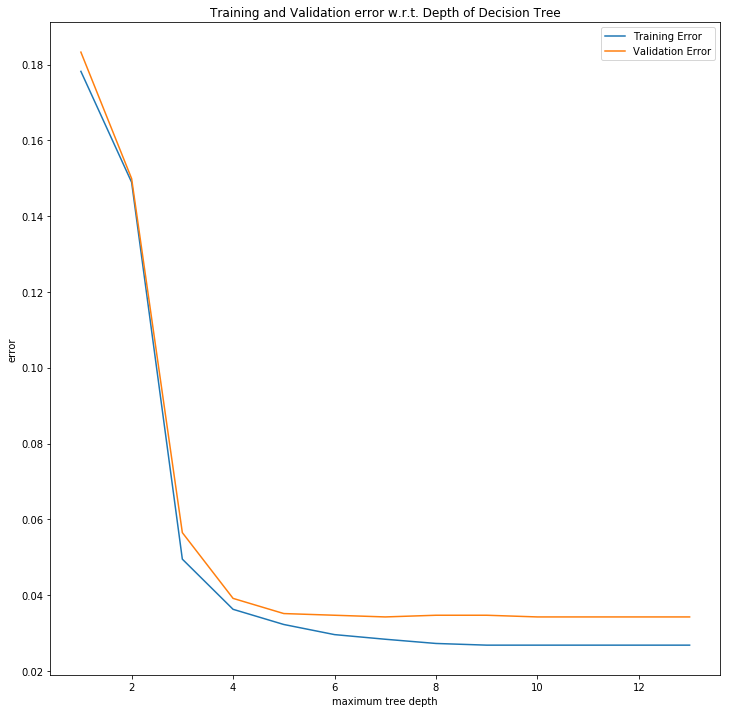

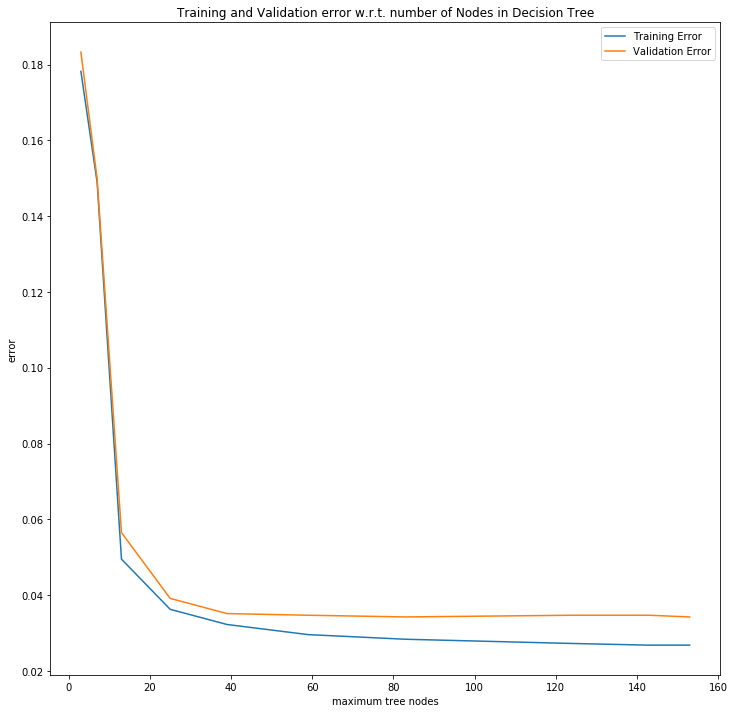

In [65]:
def plot_errors(train_data, validation_data):
    
    training_error = []
    validation_error = []
    depth_arr = []
    nodes_arr = []
    
    max_depth = 1
    while max_depth < 14:
        
        global nodes_count
        nodes_count = 1
        
        decision_tree = build_decision_tree(train_data, X, max_depth)
    
        TP = 0
        TN = 0
        FP = 0
        FN = 0
        for i in range(len(train_data.index)):
            row = train_data.iloc[[i]][Y]
            row = row.tolist()
            row = row[0]
            if predict(train_data.iloc[[i]], decision_tree) == 1:
                if row == 1:
                    TP += 1
                else:
                    FP += 1
            else:
                if row == 0:
                    TN += 1
                else:
                    FN += 1
        training_error.append( float(FP + FN) / (TP + TN + FP + FN) )
        
        TP = 0
        TN = 0
        FP = 0
        FN = 0
        for i in range(len(validation_data.index)):
            row = validation_data.iloc[[i]][Y]
            row = row.tolist()
            row = row[0]
            if predict(validation_data.iloc[[i]], decision_tree) == 1:
                if row == 1:
                    TP += 1
                else:
                    FP += 1
            else:
                if row == 0:
                    TN += 1
                else:
                    FN += 1
        validation_error.append( float(FP + FN) / (TP + TN + FP + FN) )
        
        depth_arr.append(max_depth)
        nodes_arr.append(nodes_count)
        
        max_depth += 1
    
    plt.figure(figsize=(12,12))
    plt.plot(depth_arr, training_error, label = "Training Error")
    plt.plot(depth_arr, validation_error, label = "Validation Error")
    plt.xlabel('maximum tree depth') 
    plt.ylabel('error')
    plt.title('Training and Validation error w.r.t. Depth of Decision Tree') 
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(12,12))
    plt.plot(nodes_arr, training_error, label = "Training Error")
    plt.plot(nodes_arr, validation_error, label = "Validation Error")
    plt.xlabel('maximum tree nodes') 
    plt.ylabel('error')
    plt.title('Training and Validation error w.r.t. number of Nodes in Decision Tree') 
    plt.legend()
    plt.show()


plot_errors(data, validation_data)

Observations:

1. It can be sen that the training and validation errors decrease as we increase number of nodes.
2. The validation error is more than the training error.

# Part 6: Handling missing values(attributes missing in test samples) in data

The decision tree cannot directly handle test samples that have missing attributes.

The basic approach during classification is to use the decisions at nodes wherever possible i.e. when the test sample has a feature that is not missing.
But when the test sample is missing a attribute, use alternate queries.
During training, in addition to primary split, each non leaf node is given an ordered set of surrogate splits, having an atrribute label and a rule.
A simple measure of prediction is of two splits s1 and s2, is the count of patterns that are sent to the left by both s1 and s2 plus the count of patterns sent to right by both s1 and s2.
The second surrogate split is defined as the one that uses another feature and best approximates the primary split in this way.
Now during classification we use the first surrogate split that does not involve the test's row missing attributes.
This strategy uses to maximum advantage, the association among attributes to decide the split when attributes values are missing.

A simple method to handle missing attributes is to use simple probability. Whenever a test sample has a missing attribute, go to all its children and count the number of labels in each leaf encountered. This count can be stored in the node itself.
Then predict the label which has maximum count.

Another method closely related to surrogate splits is that of virtual values, in which the missing attribute is assigned its most likely value.

Sometimes the fact that we have a missing attribute can even be informative. e.g. in medical diagnosis, the fact that an attribute is missing might imply that physisian had some reason that he did not measure it.
As such a missing attribute could be represented as a new feature and could be used in classification.